In [ ]:
import copy # copy variables
import os   # manage paths

import uproot   # use of root files
import awkward as ak    # nested, variable sized data
import vector   # lorentz vectors
vector.register_awkward()
import matplotlib.pyplot as plt # plotting
import atlasopenmagic as atom

from src.parse_atlas import (parser, consts, schemas, combinatorics)

import traceback
%load_ext autoreload
%autoreload 2

In [ ]:
#TESTING MC files
mc_rec_id = atlasparser.fetch_mc_files_ids('2024', is_random=True)
all_metadata = atom.get_metadata(mc_rec_id)
urls = atom.get_urls(mc_rec_id)
atlasparser.parsing_pipeline(schemas.GENERIC_SCHEMA, files_ids=urls)

In [ ]:
#TESTING MAIN PIPELINE
import main_pipeline

main_pipeline.run()

In [ ]:
#TEST FOR KEYS OF ROOT FILE
from src.parse_atlas import parser, schemas
import atlasopenmagic as atom
parse = parser.ATLAS_Parser()
rand_id = parse.fetch_mc_files_ids(
    '2024', is_random=True)
uri = atom.get_urls(rand_id)[0]
# testing = parse.testing_load_file_as_object(uri)
testing = parse._parse_file(
    schema=schemas.GENERIC_SCHEMA, 
    file_index=uri)

In [ ]:
dir(testing)
testing.fields

In [ ]:
GeV = 1000.

def selected_electrons(el):
    return el[(el.pt > 10 * GeV) & (abs(el.eta) < 2.47)]

def selected_muons(mu):
    return mu[(mu.pt > 10 * GeV) & (abs(mu.eta) < 2.47)]

def selected_jets(j):
    return j[(j.pt > 10 * GeV) & (abs(j.eta) < 2.47)]

def no_overlap(obj1, obj2, deltaR=0.4):
    obj1, obj2 = ak.unzip(ak.cartesian([obj1, obj2], nested=True))
    return ak.all(obj1.deltaR(obj2) > deltaR, axis=-1)

def mjjj(jets):
    candidates = ak.combinations(jets, 3)
    j1, j2, j3 = ak.unzip(candidates)
    candidates["p4"] = j1 + j2 + j3
    candidates = candidates[ak.argmax(candidates.p4.pt, axis=1, keepdims=True)]
    return candidates.p4.mass

def processed(events):
    events = copy.copy(events) # shallow copy
    events["Electrons"] = selected_electrons(events.Electrons)
    events["Muons"] = selected_muons(events.Muons)
    events["Jets"] = selected_jets(events.Jets)
    events["Jets"] = events.Jets[no_overlap(events.Jets, events.Electrons)]
    events = events[
        (ak.num(events.Jets) >= 4) # at least 4 jets
        & ((ak.num(events.Electrons) + ak.num(events.Muons)) == 1) # exactly one lepton
    ]
    return ak.to_packed(events)

events = processed(atlasparser.events)
plt.hist(ak.flatten(mjjj(events.Jets) / GeV, axis=None), bins=100)
plt.xlabel("Reconstructed Top Quark Mass (GeV)")
plt.ylabel("Number of Events")
plt.title("Distribution of Reconstructed Top Quark Mass")
plt.axvline(172.76, color='r', linestyle='dashed', linewidth=2, label='Expected Top Quark Mass')
plt.legend()
plt.show()

print('Total events:', len(atlasparser.events))
print('Events after filtering:', len(events))

In [ ]:
def selected_electrons(el):
    return el[(el.pt > 10 * GeV) & (abs(el.eta) < 2.47)]

def electron_posi_muon_antimuon(events):
    events = copy.copy(events) # shallow copy
    events["Electrons"] = selected_electrons(events.Electrons)
    events["Muons"] = selected_muons(events.Muons)
    events["Electrons", "is_neg"] = events.Electrons.charge < 0
    events["Muons", "is_neg"] = events.Muons.charge < 0
    events = events[
        (ak.num(events.Electrons) == 2) 
        & (ak.num(events.Muons) == 2)
        # & (ak.num(events.Electrons[events.Electrons.is_neg]) == 1)
        # & (ak.num(events.Muons[events.Muons.is_neg]) == 1)
    ]
    return ak.to_packed(events)

events = electron_posi_muon_antimuon(atlasparser.events)
plt.hist(ak.flatten(events) / GeV, axis=None, bins=100)
plt.xlabel("Reconstructed Top Quark Mass (GeV)")
plt.ylabel("Number of Events")
plt.title("Distribution of Reconstructed Top Quark Mass")
plt.axvline(172.76, color='r', linestyle='dashed', linewidth=2, label='Expected Top Quark Mass')
plt.legend()
plt.show()

print('Total events:', len(atlasparser.events))
print('Events after filtering:', len(events))

Starting to parse 7 files with 3 threads.


Parsing files:   0%|          | 0/7 [00:00<?, ?file/s]

Parsing files:  14%|█▍        | 1/7 [00:04<00:29,  4.99s/file, 48.00 KB | root://eospublic.cern.ch//eos/opendata/atlas/rucio/data15_13TeV/DAOD_PHYSLITE.37001626._000005.pool.root.1]

Parsed file with objects: ['Electrons', 'Muons', 'Jets', 'Photons']


Parsing files:  29%|██▊       | 2/7 [00:08<00:19,  3.93s/file, 96.00 KB | root://eospublic.cern.ch//eos/opendata/atlas/rucio/data15_13TeV/DAOD_PHYSLITE.37001626._000007.pool.root.1]

Parsed file with objects: ['Electrons', 'Muons', 'Jets', 'Photons']


Parsing files:  43%|████▎     | 3/7 [00:11<00:14,  3.52s/file, 144.00 KB | root://eospublic.cern.ch//eos/opendata/atlas/rucio/data15_13TeV/DAOD_PHYSLITE.37001626._000004.pool.root.1]

Parsed file with objects: ['Electrons', 'Muons', 'Jets', 'Photons']


Parsing files:  57%|█████▋    | 4/7 [00:13<00:08,  2.97s/file, 192.00 KB | root://eospublic.cern.ch//eos/opendata/atlas/rucio/data15_13TeV/DAOD_PHYSLITE.37001626._000006.pool.root.1]

Parsed file with objects: ['Electrons', 'Muons', 'Jets', 'Photons']


Parsing files:  71%|███████▏  | 5/7 [00:16<00:05,  2.94s/file, 240.00 KB | root://eospublic.cern.ch//eos/opendata/atlas/rucio/data15_13TeV/DAOD_PHYSLITE.37001626._000008.pool.root.1]

Parsed file with objects: ['Electrons', 'Muons', 'Jets', 'Photons']


Parsing files:  86%|████████▌ | 6/7 [00:20<00:03,  3.29s/file, 288.00 KB | root://eospublic.cern.ch//eos/opendata/atlas/rucio/data15_13TeV/DAOD_PHYSLITE.37001626._000009.pool.root.1]

Parsed file with objects: ['Electrons', 'Muons', 'Jets', 'Photons']


Parsing files: 100%|██████████| 7/7 [00:34<00:00,  4.91s/file, 336.00 KB | root://eospublic.cern.ch//eos/opendata/atlas/rucio/data15_13TeV/DAOD_PHYSLITE.37001626._000010.pool.root.1]


Parsed file with objects: ['Electrons', 'Muons', 'Jets', 'Photons']
Yielding final chunk with total 7 files.
Processing category: {'Electrons': 3, 'Muons': 2, 'Jets': 4, 'Photons': 4}
Number of events in combination {'Electrons': 3, 'Muons': 2, 'Jets': 1, 'Photons': 4}: 27


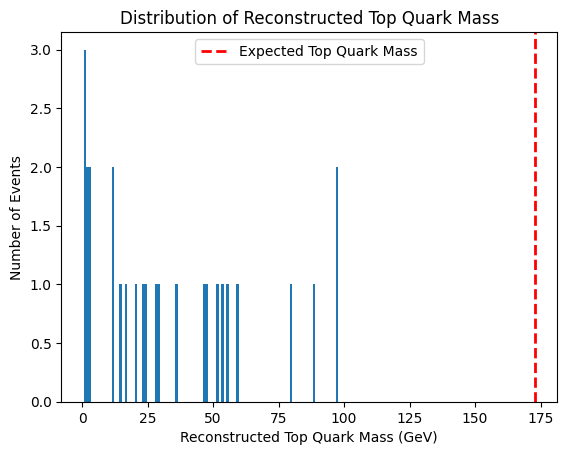

ZeroDivisionError: division by zero

In [ ]:
import logging
import sys
from src.parse_atlas import parser, combinatorics, consts, schemas
import matplotlib.pyplot as plt # plotting
import awkward as ak
import tqdm
import random

release_years = ['2016', '2020', '2024', '2025']

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

def run():
    atlasparser = parser.ATLAS_Parser()
    release_files_uris = atlasparser.fetch_records_ids(release_year='2024')

    categories = combinatorics.make_objects_categories(schemas.PARTICLE_LIST, min_n=2, max_n=4)

    # for events_chunk in atlasparser.parse_files(files_ids=random.sample(release_files_uris, k=1)):
    for events_chunk in atlasparser.parse_files(files_ids=release_files_uris, limit=30):
        for category in categories:
            print(f"Processing category: {category}")    

            combination_dict_gen = combinatorics.make_objects_combinations_for_category(
                    category, min_k=2, max_k=4)
            combination_dict = next(combination_dict_gen)
            #IF CAN FILTER ACCORDING TO ITERATION'S COMBINATION
            if not all(obj in events_chunk.fields for obj in combination_dict.keys()):
                logging.info ('Not all of the combination objects are present in the events chunk. ')
                continue    
            
            combo_events = atlasparser.filter_events_by_combination(
                events_chunk, combination_dict)

            combination_events_mass = atlasparser.calculate_mass_for_combination(combo_events)
            
            #COMBO_EVENTS IS THE EVENTS FILTERED FOR EACH COMBINTATION
            #NEXT STEP, MAKE A MASS HIST OUT OF IT
            plt.hist(ak.flatten(combination_events_mass / consts.GeV, axis=None), bins=100)
            plt.xlabel("Reconstructed Top Quark Mass (GeV)")
            plt.ylabel("Number of Events")
            plt.title("Distribution of Reconstructed Top Quark Mass")
            plt.axvline(172.76, color='r', linestyle='dashed', linewidth=2, label='Expected Top Quark Mass')
            plt.legend()
            plt.show()
            0/0
            
run()